
# Exploratory Data Analysis (EDA) - CS Ops Churn Prediction
# 
# **Objective:** Explore the `fct_customer_kpis` table (created by dbt) to understand customer characteristics, identify patterns related to churn, and inform Machine Learning modeling.

**Observações Iniciais:**
* O dataset contém 9800 linhas e 19 colunas após o carregamento do BigQuery (excluindo `company_name`).
* Os tipos de dados parecem corretos após o processamento do dbt (`mrr` é float, datas estão apropriadas).
* Verificado usando `df.info()`, não há valores ausentes no dataset limpo, confirmando as etapas de limpeza.
* As features numéricas mostram uma ampla gama de valores (ex: `mrr` de ~50 a ~5000, `total_minutes` até ~40000).
* Várias features como `total_critical_tickets` e `tickets_last_30d` têm mínimo de 0 e medianas baixas, sugerindo que muitos clientes têm baixas contagens para essas métricas.

In [63]:
# === 1. Import Libraries ===
import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

# Settings
warnings.filterwarnings("ignore", category=UserWarning, module="google.auth._default")
pd.set_option('display.max_columns', None) # Show all DataFrame columns
sns.set_style('whitegrid') # Plotting style
plt.rcParams['figure.figsize'] = (50, 10) # Default figure size

print("Libraries imported.")

Libraries imported.


In [64]:
# === 2. Configure Project and Load Data ===

# ----- (IMPORTANT!) Verify your PROJECT_ID -----
PROJECT_ID = "cs-ops-analytics-pipeline" # CHANGE IF YOURS IS DIFFERENT
TABLE_ID = f"{PROJECT_ID}.cs_ops_analytics.fct_customer_kpis"
# -----------------------------------------------------

print(f"Loading data from table: {TABLE_ID}")

sql = f"""
SELECT
    * except (company_name) # Exclude company name for analysis (not a feature)
FROM
    `{TABLE_ID}`
"""

# Try to load the data
try:
    df = pandas_gbq.read_gbq(sql, project_id=PROJECT_ID)
    print(f"Data loaded successfully! Shape: {df.shape}")
except Exception as e:
    print(f"Error loading data from BigQuery: {e}")
    # Add a placeholder if loading fails
    df = pd.DataFrame()

Loading data from table: cs-ops-analytics-pipeline.cs_ops_analytics.fct_customer_kpis


c:\Users\ReDragon\Desktop\customer-success-analytics-pipeline\venv\Lib\site-packages\google\cloud\bigquery\table.py:2689: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


Data loaded successfully! Shape: (9800, 19)


Contagem de Churn Status:
churn_status
0    7610
1    2190
Name: count, dtype: Int64

Porcentagem de Churn Status:
churn_status
0    77.653061
1    22.346939
Name: proportion, dtype: Float64


C:\Users\ReDragon\AppData\Local\Temp\ipykernel_6892\1124283892.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churn_status', data=df, palette='viridis')


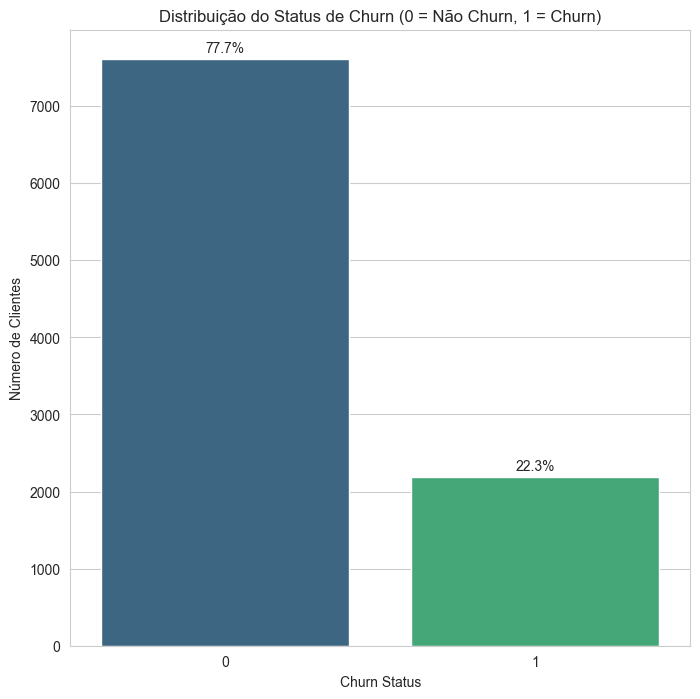

In [ ]:
# ## 4. Target Variable Analysis (Churn Status)
#
# Let's check the proportion of customers who churned versus those who did not.

# %%
# === Churn Counts and Proportions ===
churn_counts = df['churn_status'].value_counts()
churn_percentage = df['churn_status'].value_counts(normalize=True) * 100

print("Churn Status Counts:")
print(churn_counts)
print("\nChurn Status Percentage:")
print(churn_percentage)

# %%
# === Churn Distribution Visualization ===
plt.figure(figsize=(8, 8)) # Smaller plot for this simple viz
sns.countplot(x='churn_status', data=df, palette='viridis')
plt.title('Distribution of Churn Status (0 = No Churn, 1 = Churn)')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
# Add percentage annotations
for index, value in enumerate(churn_counts):
    percentage = churn_percentage[index]
    plt.text(index, value + 50, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)
plt.show()
plt.show()

**Observações sobre o Churn:**
* A variável alvo `churn_status` é desbalanceada.
* Aproximadamente 22.3% dos clientes neste dataset deram churn (2190 de 9800).
* A classe de não-churn (0) representa cerca de 77.7% dos dados.
* Este desbalanceamento justifica o uso de técnicas como `class_weight='balanced'` ou `scale_pos_weight` durante o treinamento do modelo.

Numerical Features to be analyzed:
['mrr', 'customer_tenure_days', 'total_tickets', 'total_critical_tickets', 'tickets_last_30d', 'critical_ticket_ratio', 'total_logins', 'total_minutes', 'avg_session_minutes', 'distinct_features_used', 'days_since_last_login', 'days_since_last_ticket', 'days_since_last_interaction', 'tickets_per_login']

Histograms of Numerical Features:


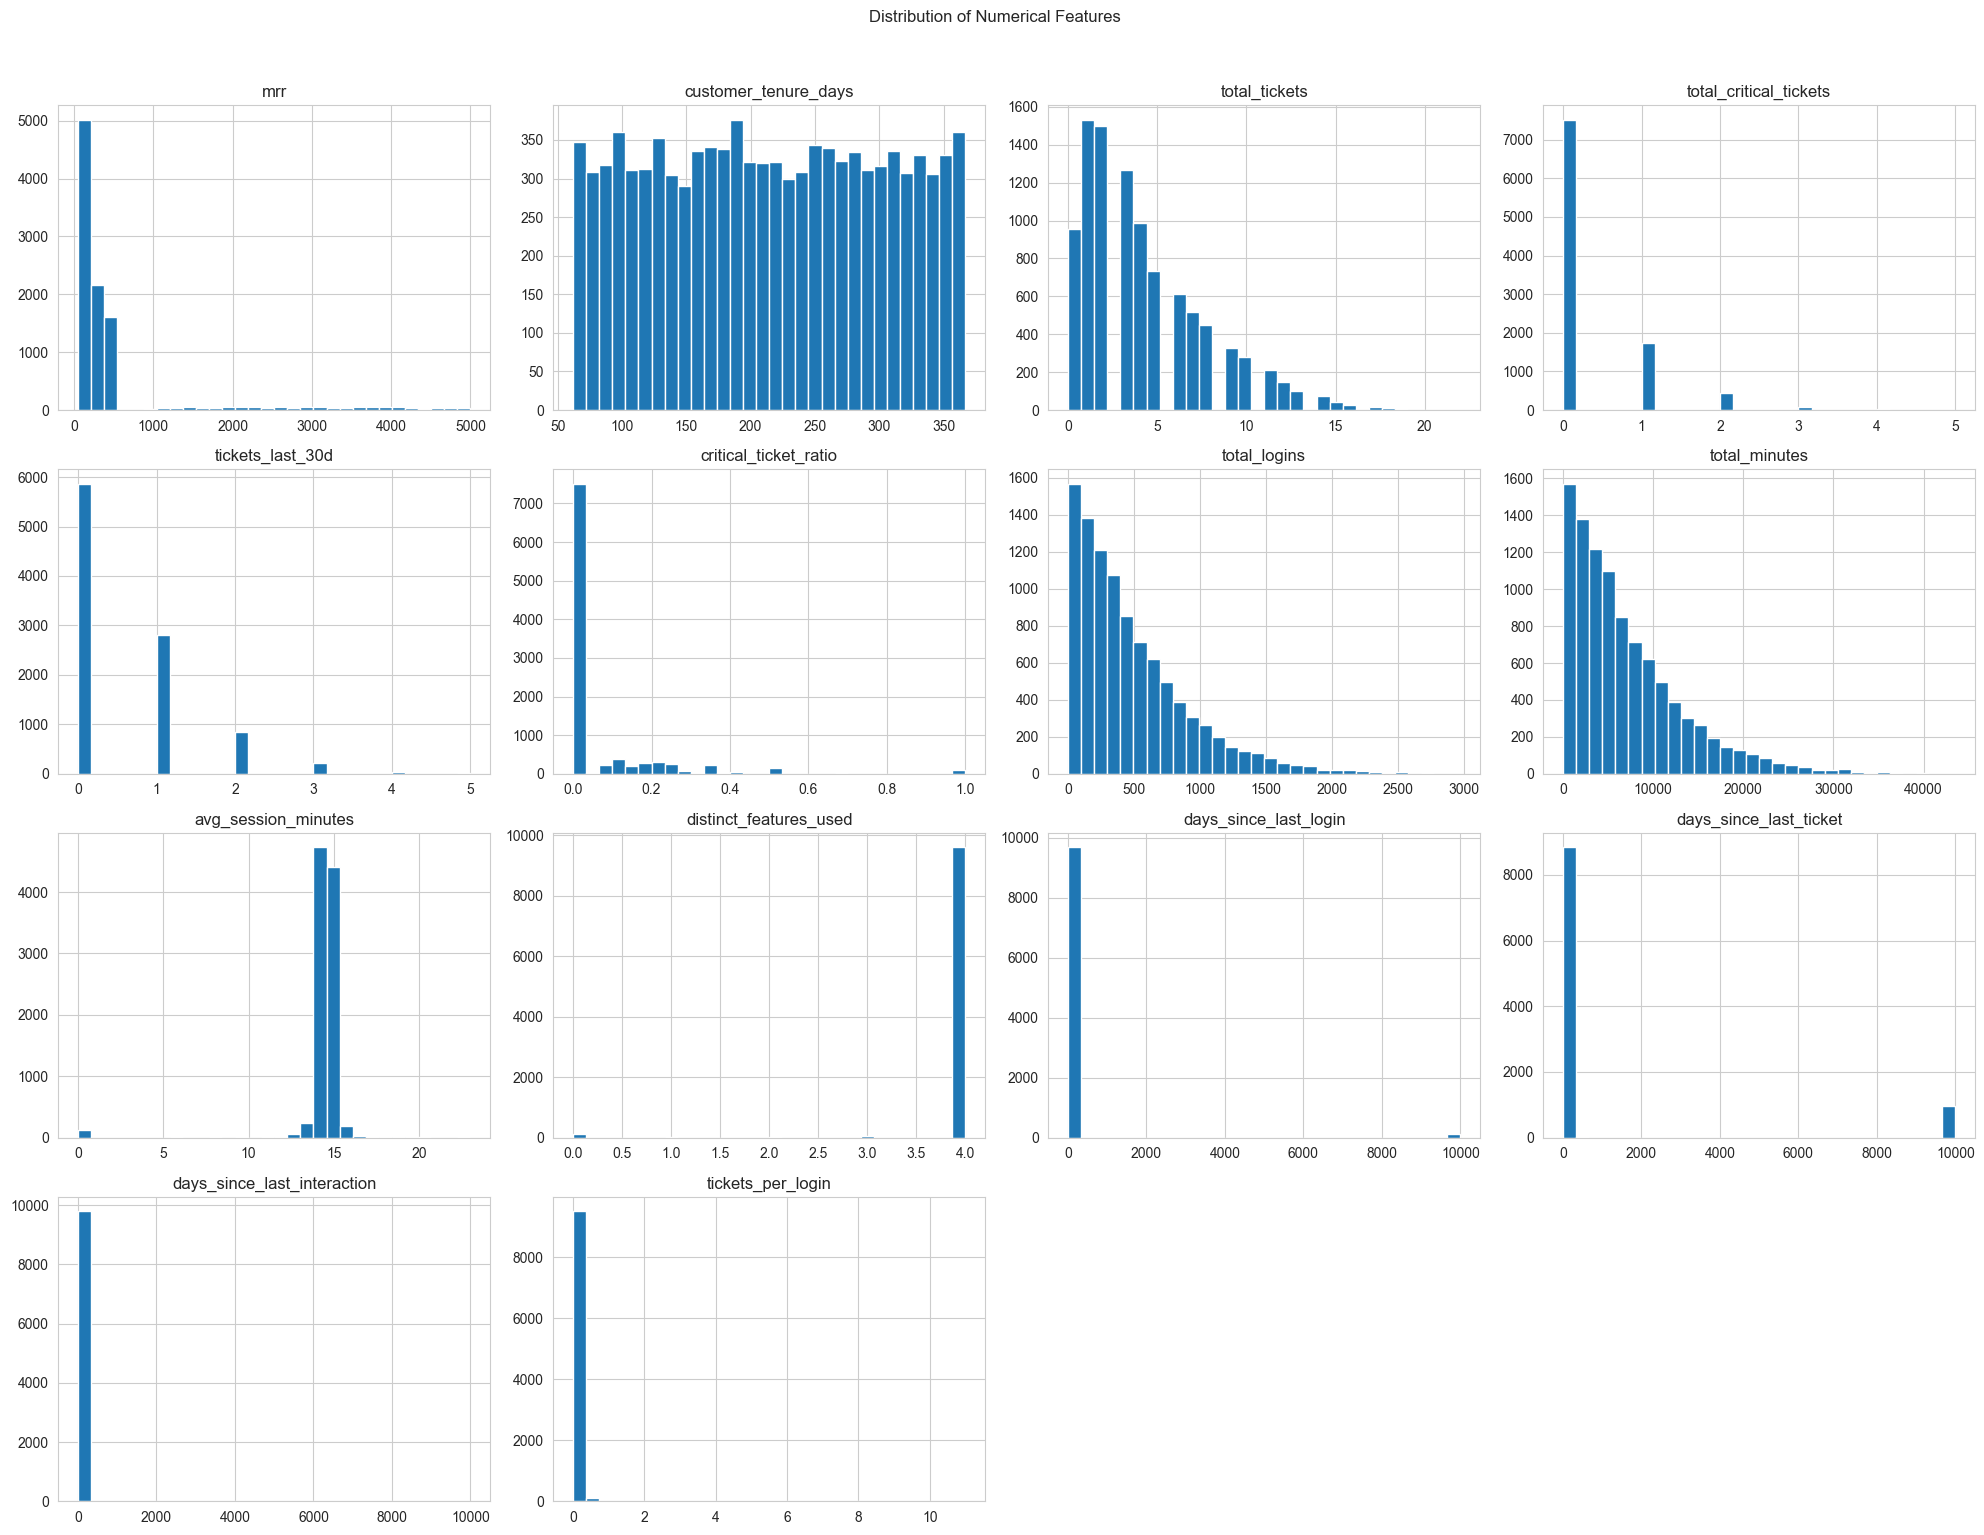


Box Plots: Comparing Numerical Features between Churn vs. Non-Churn:


C:\Users\ReDragon\AppData\Local\Temp\ipykernel_6892\539233766.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn_status', y=feature, data=df, ax=axes[i], palette='viridis')
C:\Users\ReDragon\AppData\Local\Temp\ipykernel_6892\539233766.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn_status', y=feature, data=df, ax=axes[i], palette='viridis')
C:\Users\ReDragon\AppData\Local\Temp\ipykernel_6892\539233766.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn_status', y=feature, data=df, ax=axes[i], palette='virid

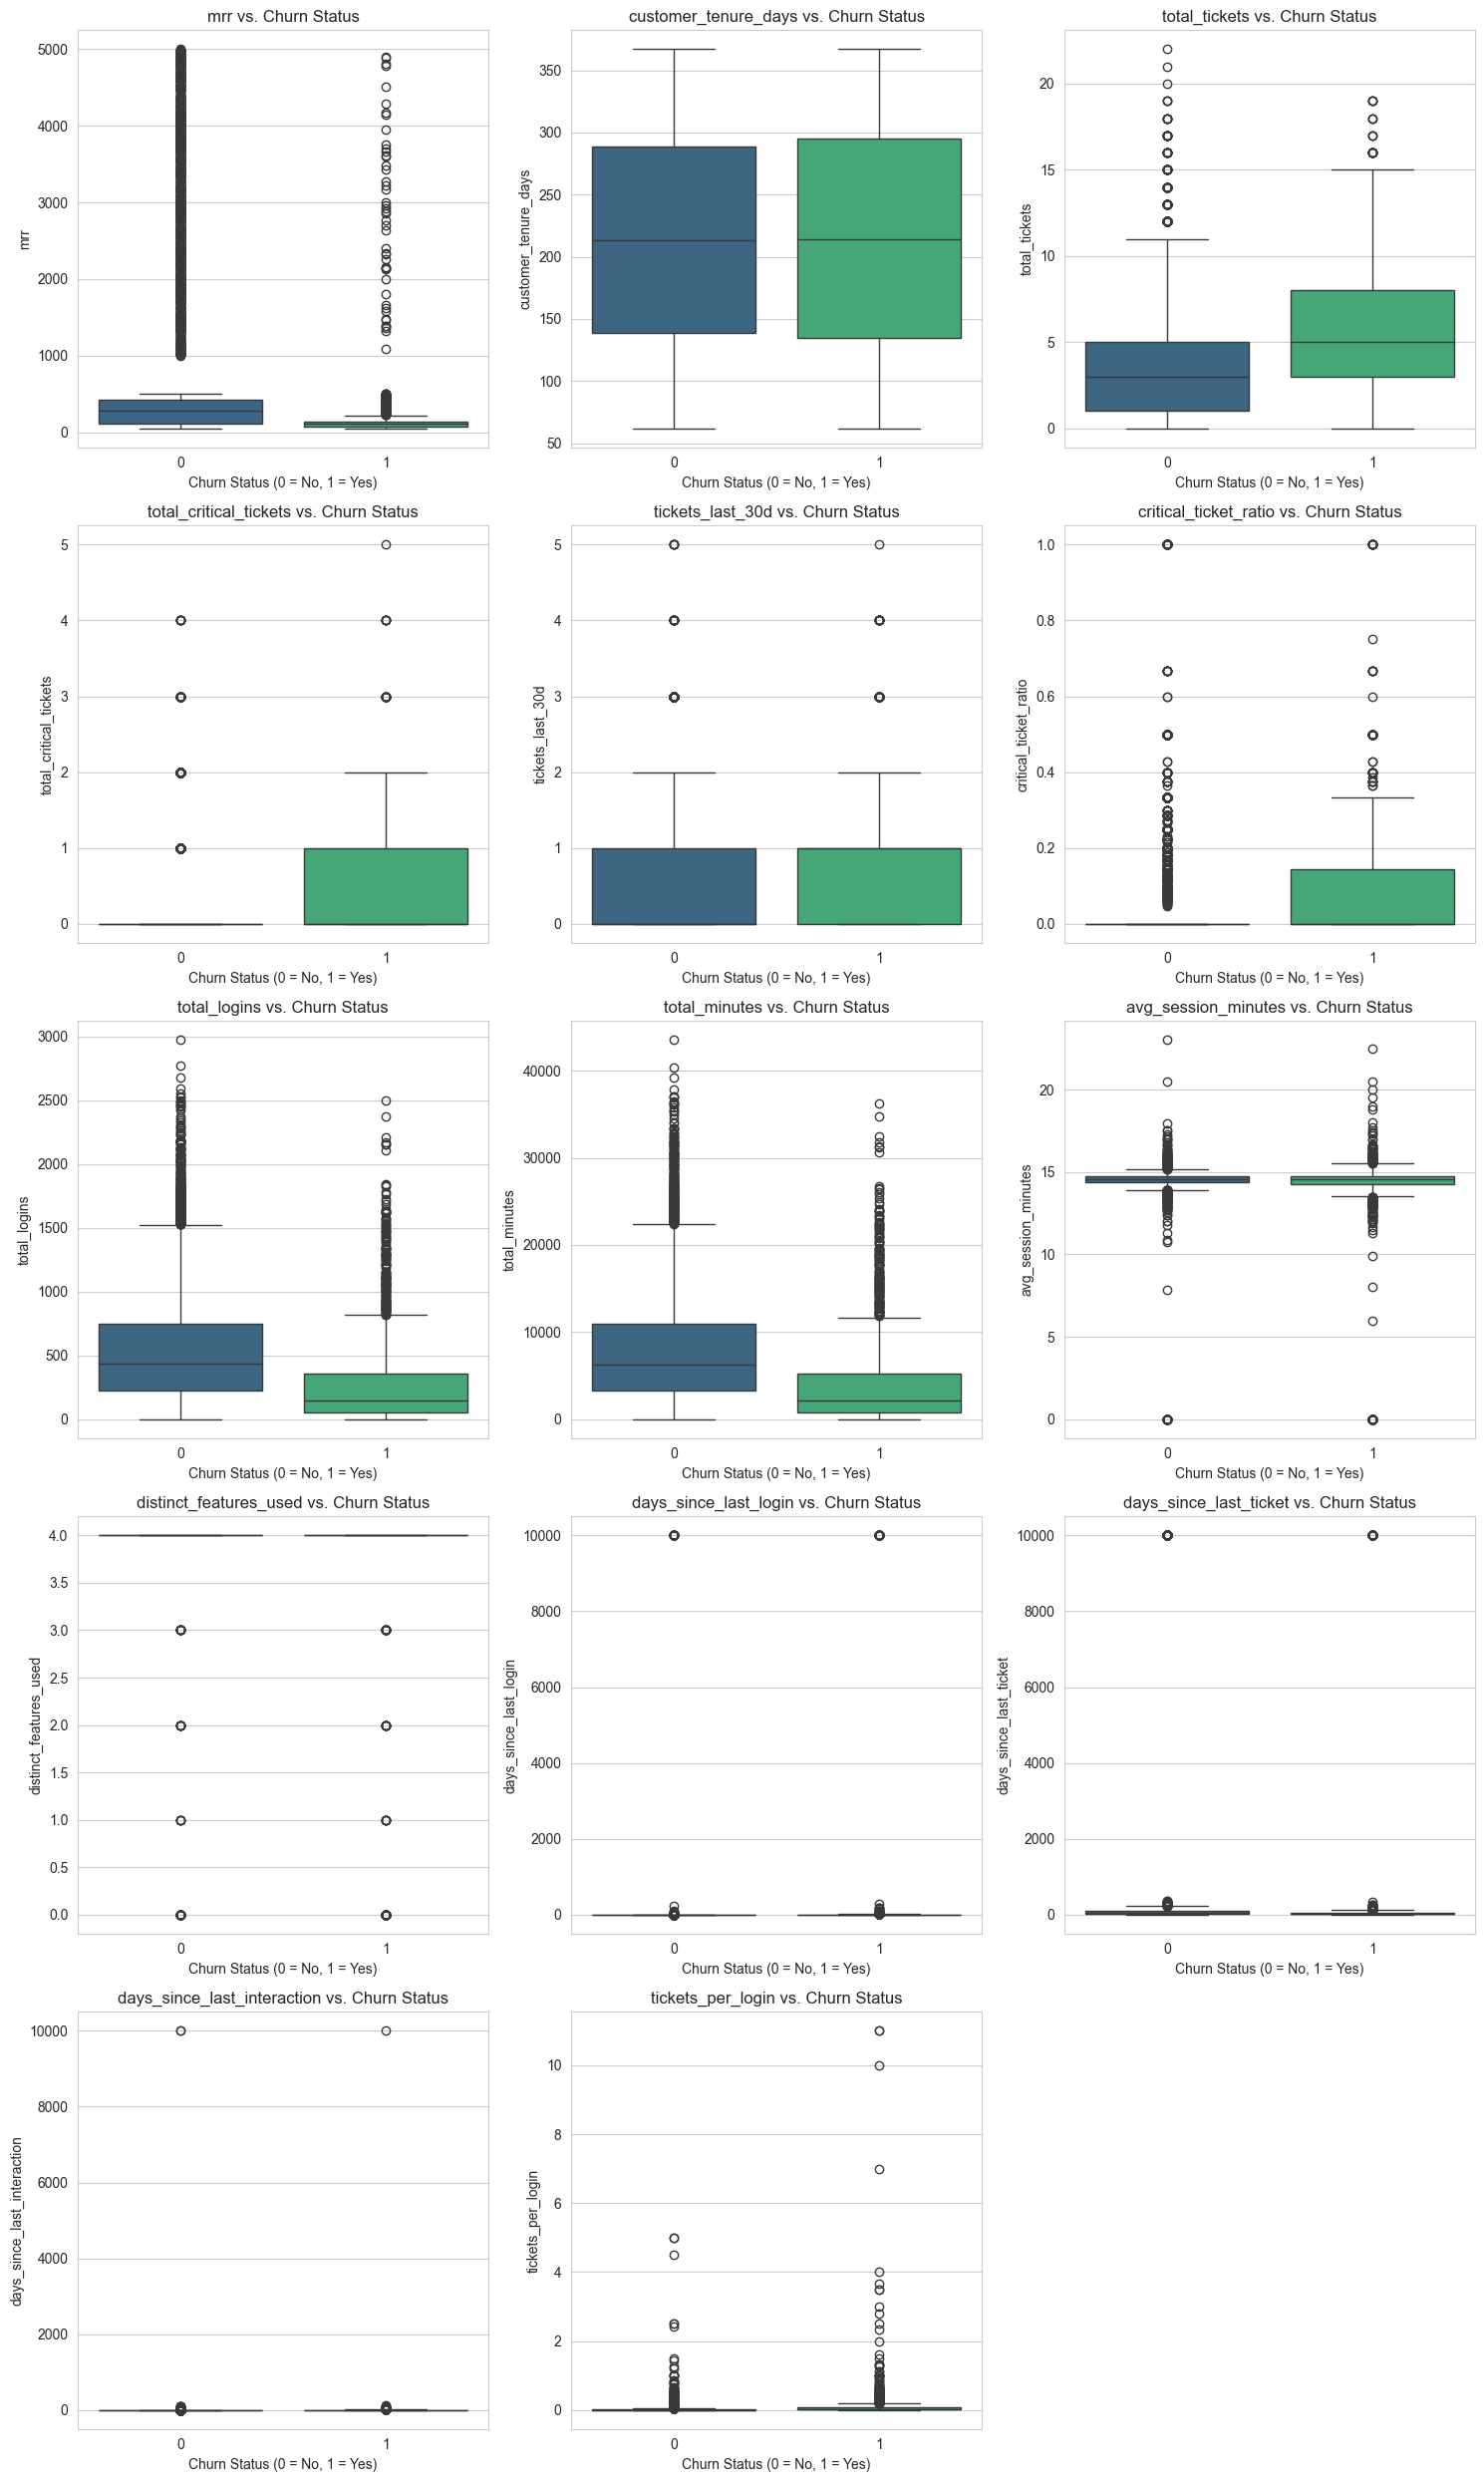

In [ ]:
# ## 5. Analysis of Numerical Features
# 
# Let's explore the distribution of numerical variables and their relationship with churn.


# === List of Numerical Features ===
# (Let's grab all numeric types except flags/status (0/1) and IDs)
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
if 'churn_status' in numerical_features: # Remove target if present
    numerical_features.remove('churn_status')
# If 'used_financial_features_flag' is numeric (0/1), remove it too
if 'used_financial_features_flag' in numerical_features:
    numerical_features.remove('used_financial_features_flag')
if 'customer_id' in numerical_features: # If customer_id is numeric
     numerical_features.remove('customer_id')

print("Numerical Features to be analyzed:")
print(numerical_features)


# === Histograms of Numerical Features ===
print("\nHistograms of Numerical Features:")
# Adjust layout based on the number of features
df[numerical_features].hist(bins=30, figsize=(20, 15), layout=(4, 4))
plt.suptitle('Distribution of Numerical Features', y=1.02)
plt.tight_layout()
plt.show()

# === Box Plots: Numerical Features vs. Churn ===
print("\nBox Plots: Comparing Numerical Features between Churn vs. Non-Churn:")

# Adjust the number of columns (ncols) based on the number of features
n_features = len(numerical_features)
n_cols = 3
# Calculate the required number of rows
n_rows = (n_features + n_cols - 1) // n_cols 

# Adjust figure size dynamically
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5)) 
# Flatten the axes array for easy iteration
axes = axes.flatten() 

for i, feature in enumerate(numerical_features):
    sns.boxplot(x='churn_status', y=feature, data=df, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{feature} vs. Churn Status')
    axes[i].set_xlabel('Churn Status (0 = No, 1 = Yes)')
    axes[i].set_ylabel(feature)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**Observações sobre as Distribuições:**
* A maioria das features baseadas em contagem (`total_tickets`, `total_logins`, `total_minutes`) e `mrr` são fortemente assimétricas à direita, o que é típico para dados de comportamento de usuário.
* Features de recência (`days_since_last_login`, `days_since_last_ticket`, `days_since_last_interaction`) também são fortemente assimétricas à direita, com a maioria dos clientes tendo interagido recentemente.
* `customer_tenure_days` mostra uma distribuição relativamente uniforme.
* `avg_session_minutes` parece mais próxima de uma distribuição normal, centrada em torno de 15-20 minutos.
* Features como `critical_ticket_ratio` e `tickets_per_login` são infladas em zero (muitos clientes têm valor 0).

Customer Count per Plan:
plan
basic         4537
pro           3764
enterprise    1051
undefined      448
Name: count, dtype: int64

Customer Percentage per Plan:
plan
basic         46.295918
pro           38.408163
enterprise    10.724490
undefined      4.571429
Name: proportion, dtype: float64


C:\Users\ReDragon\AppData\Local\Temp\ipykernel_6892\1588386489.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='plan', data=df, order=plan_counts.index, palette='viridis')


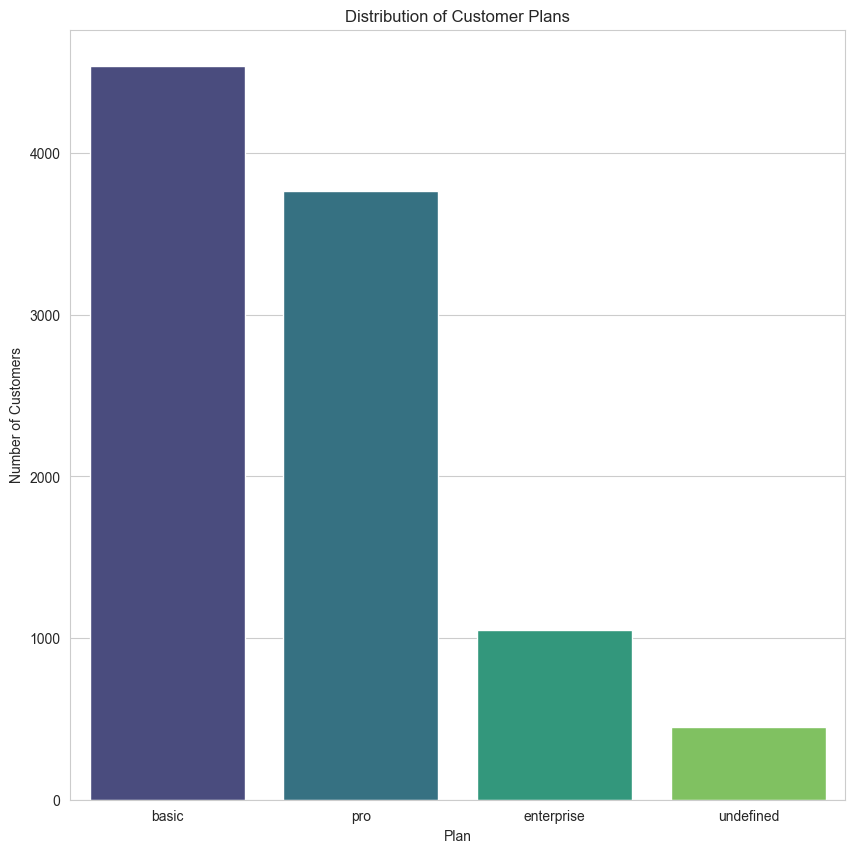


Churn Rate (%) per Plan:
plan
basic         38.329292
undefined     22.098214
enterprise     7.326356
pro            7.306057
Name: churn_status, dtype: Float64


C:\Users\ReDragon\AppData\Local\Temp\ipykernel_6892\1588386489.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate_by_plan.index, y=churn_rate_by_plan.values, palette='viridis')


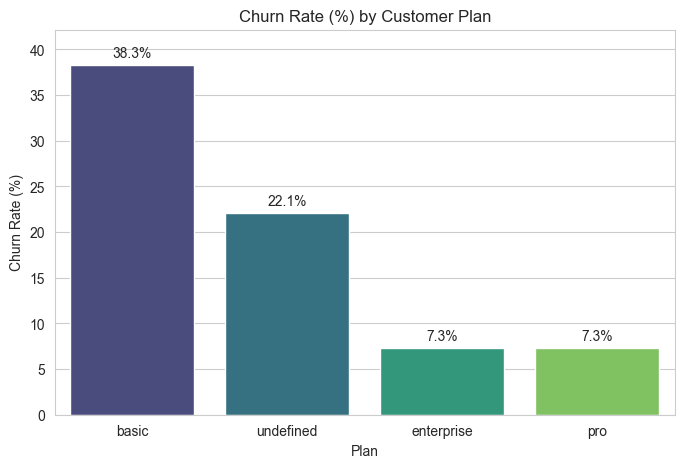

In [ ]:
# ## 6. Analysis of Categorical Features
#
# Let's analyze the `plan` feature and its relationship with churn.

# === Distribution of Plans ===
plan_counts = df['plan'].value_counts()
plan_percentage = df['plan'].value_counts(normalize=True) * 100

print("Customer Count per Plan:")
print(plan_counts)
print("\nCustomer Percentage per Plan:")
print(plan_percentage)

plt.figure(figsize=(10, 10))
sns.countplot(x='plan', data=df, order=plan_counts.index, palette='viridis')
plt.title('Distribution of Customer Plans')
plt.xlabel('Plan')
plt.ylabel('Number of Customers')
plt.show()

# === Churn Rate per Plan ===
churn_rate_by_plan = df.groupby('plan')['churn_status'].mean() * 100 # Calculate mean (which is % for 0/1)
churn_rate_by_plan = churn_rate_by_plan.sort_values(ascending=False)

print("\nChurn Rate (%) per Plan:")
print(churn_rate_by_plan)

plt.figure(figsize=(8, 5))
sns.barplot(x=churn_rate_by_plan.index, y=churn_rate_by_plan.values, palette='viridis')
plt.title('Churn Rate (%) by Customer Plan')
plt.xlabel('Plan')
plt.ylabel('Churn Rate (%)')
plt.ylim(0, churn_rate_by_plan.max() * 1.1) # Adjust y-axis limit

# Add percentage labels
for index, value in enumerate(churn_rate_by_plan.values):
    plt.text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)
plt.show()

**Observações sobre Box Plots vs. Churn:**
* **Indicadores Claros:** Várias features mostram diferenças significativas entre clientes que deram churn (1) e os que não deram (0):
    * `days_since_last_login` e `days_since_last_interaction` são drasticamente maiores para clientes que deram churn (indicando que inatividade é um forte fator de risco).
    * `total_logins` e `total_minutes` são significativamente menores para clientes que deram churn (indicando menor engajamento).
    * `total_critical_tickets` e `critical_ticket_ratio` mostram valores mais altos e maior dispersão para clientes que deram churn (indicando que problemas estão ligados ao churn).
    * `total_tickets` também mostra valores mais altos para churners.
    * `mrr` parece ligeiramente menor para clientes que deram churn.
* **Indicadores Menos Claros:** Features como `customer_tenure_days` e `avg_session_minutes` mostram distribuições muito similares para ambos os grupos nestes dados simulados. `distinct_features_used` mostra apenas uma leve diferença.
* **Conclusão:** Recência, volume de uso e problemas críticos parecem ser os direcionadores mais fortes de churn neste dataset, validando as features escolhidas para o modelo de ML.

**Observações sobre o Plano do Cliente:**
* O plano `basic` é o mais comum, seguido pelo `pro`. `enterprise` e `undefined` têm menos clientes.
* Existe uma correlação muito forte entre `plan` e `churn_status`. O plano `basic` tem uma taxa de churn significativamente mais alta (~38%) comparado ao `pro` e `enterprise` (~7%).
* A categoria `undefined` tem uma taxa de churn intermediária (~22%).
* Isso confirma a lógica simulada e destaca `plan` como uma feature categórica potencialmente importante para o modelo (embora modelos baseados em árvore como o LightGBM possam lidar com ela diretamente se codificada).